## 1. Dependencies and Configuration


In [64]:
# ============================================================================
# CONFIGURABLE HYPERPARAMETERS
# ============================================================================

# Quantum Kernel Parameters
N_QUBITS = 4  # Number of qubits for quantum feature map (adjust based on PCA components)
N_LAYERS = 2  # Number of layers in the quantum feature map
USE_HARDWARE = False  # Set to True if you have IBM Quantum credentials
IBM_DEVICE = 'ibmq_qasm_simulator'  # Change to actual device name if using hardware

# Classical Model Parameters
N_SPLITS = 5  # Number of folds for cross-validation
RANDOM_STATE = 42
TEST_SIZE = 0.2  # For final train/test split

# PCA Parameters
PCA_VARIANCE_THRESHOLD = 0.95  # Retain 95% variance (will determine actual n_components)

# Bootstrap Parameters
N_BOOTSTRAP = 1000  # Number of bootstrap samples for confidence intervals
CONFIDENCE_LEVEL = 0.95  # 95% confidence intervals

# File Paths
DATA_PATH_VOICE = 'parkinsons/parkinsons.data'
DATA_PATH_TELEMON = 'parkinsons/telemonitoring/parkinsons_updrs.data'
OUTPUT_DIR = 'outputs'

# Create output directory
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [50]:
# ============================================================================
# INSTALL DEPENDENCIES (uncomment if needed)
# ============================================================================
!pip install numpy pandas scikit-learn matplotlib seaborn pennylane qiskit qiskit-ibm-provider scipy joblib tqdm


In [51]:
# ============================================================================
# IMPORTS
# ============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score
)
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Quantum computing imports
import pennylane as qml
from pennylane import numpy as pnp

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All imports successful")


✓ All imports successful


## 2. Data Loading and Preprocessing


### 2.1 Load UCI Parkinsons Voice Dataset

This dataset contains voice measurements from 31 people (23 with PD, 8 healthy). Each person has multiple recordings.


In [52]:
# Load the main Parkinsons voice dataset
df_voice = pd.read_csv(DATA_PATH_VOICE)

print(f"Dataset shape: {df_voice.shape}")
print(f"\nColumn names:\n{df_voice.columns.tolist()}")
print(f"\nFirst few rows:")
df_voice.head()


Dataset shape: (195, 24)

Column names:
['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE']

First few rows:


,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [53]:
# Extract subject IDs from the 'name' column
# Format: phon_R01_S01_1 -> subject ID is S01
df_voice['subject_id'] = df_voice['name'].str.extract(r'S(\d+)')[0].astype(int)

# Separate features and target
feature_cols = [col for col in df_voice.columns if col not in ['name', 'status', 'subject_id']]
X = df_voice[feature_cols].values
y = df_voice['status'].values
subject_ids = df_voice['subject_id'].values

print(f"Number of features: {len(feature_cols)}")
print(f"Feature names: {feature_cols}")
print(f"\nClass distribution:")
print(f"  Healthy (0): {np.sum(y == 0)} samples")
print(f"  Parkinson's (1): {np.sum(y == 1)} samples")
print(f"\nNumber of unique subjects: {len(np.unique(subject_ids))}")
print(f"Subjects per class:")
for subject in np.unique(subject_ids):
    subject_mask = subject_ids == subject
    subject_class = y[subject_mask][0]
    print(f"  Subject {subject}: {np.sum(subject_mask)} recordings, class={subject_class}")


Number of features: 22
Feature names: ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE']

Class distribution:
  Healthy (0): 48 samples
  Parkinson's (1): 147 samples

Number of unique subjects: 32
Subjects per class:
  Subject 1: 6 recordings, class=1
  Subject 2: 6 recordings, class=1
  Subject 4: 6 recordings, class=1
  Subject 5: 6 recordings, class=1
  Subject 6: 6 recordings, class=1
  Subject 7: 6 recordings, class=0
  Subject 8: 6 recordings, class=1
  Subject 10: 6 recordings, class=0
  Subject 13: 6 recordings, class=0
  Subject 16: 6 recordings, class=1
  Subject 17: 6 recordings, class=0
  Subject 18: 6 recordings, class=1
  Subject 19: 6 recordings, class=1
  Subject 20: 6 recordings, class=1
  Subject 21: 7 recordings, class=1
  Subject 22: 6 r

### 2.2 Load Telemonitoring Dataset (Optional - for additional analysis)


In [54]:
# Load telemonitoring dataset (for reference/exploration)
df_telemon = pd.read_csv(DATA_PATH_TELEMON)

print(f"Telemonitoring dataset shape: {df_telemon.shape}")
print(f"\nNumber of unique subjects: {df_telemon['subject#'].nunique()}")
print(f"\nColumns: {df_telemon.columns.tolist()}")
df_telemon.head()


Telemonitoring dataset shape: (5875, 22)

Number of unique subjects: 42

Columns: ['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']


,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


## 3. Exploratory Data Analysis (EDA)


### 3.1 Summary Statistics


In [55]:
# Summary statistics
df_features = df_voice[feature_cols]
summary_stats = df_features.describe()
print("Summary Statistics:")
print(summary_stats)

# Save to file
summary_stats.to_csv(f"{OUTPUT_DIR}/summary_statistics.csv")
print(f"\n✓ Saved summary statistics to {OUTPUT_DIR}/summary_statistics.csv")


Summary Statistics:
       MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
count   195.000000    195.000000    195.000000      195.000000   
mean    154.228641    197.104918    116.324631        0.006220   
std      41.390065     91.491548     43.521413        0.004848   
min      88.333000    102.145000     65.476000        0.001680   
25%     117.572000    134.862500     84.291000        0.003460   
50%     148.790000    175.829000    104.315000        0.004940   
75%     182.769000    224.205500    140.018500        0.007365   
max     260.105000    592.030000    239.170000        0.033160   

       MDVP:Jitter(Abs)    MDVP:RAP    MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
count        195.000000  195.000000  195.000000  195.000000    195.000000   
mean           0.000044    0.003306    0.003446    0.009920      0.029709   
std            0.000035    0.002968    0.002759    0.008903      0.018857   
min            0.000007    0.000680    0.000920    0.002040      0.009540   


### 3.2 Class Balance Analysis


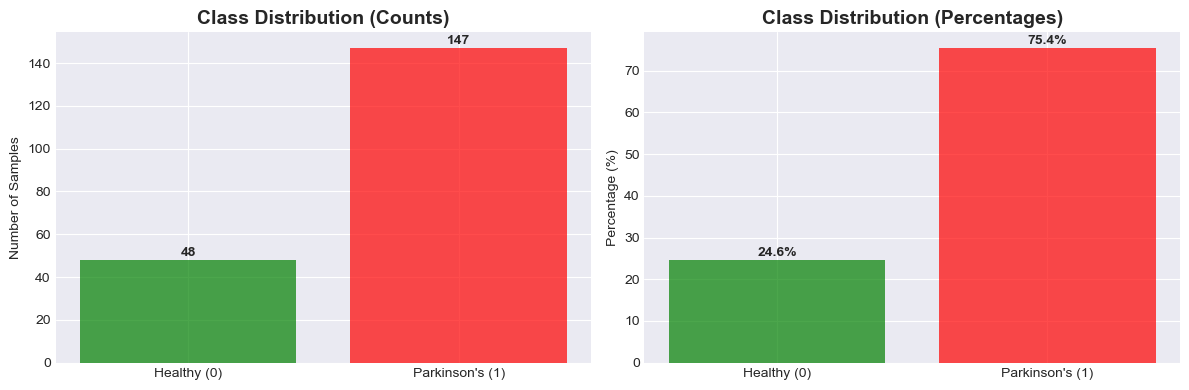

Class balance ratio: 0.33:1 (healthy:PD)
Dataset is imbalanced


In [56]:
# Class distribution
class_counts = pd.Series(y).value_counts().sort_index()
class_props = pd.Series(y).value_counts(normalize=True).sort_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
axes[0].bar(['Healthy (0)', "Parkinson's (1)"], class_counts.values, color=['green', 'red'], alpha=0.7)
axes[0].set_title('Class Distribution (Counts)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Samples')
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 2, str(v), ha='center', fontweight='bold')

# Proportion plot
axes[1].bar(['Healthy (0)', "Parkinson's (1)"], class_props.values * 100, color=['green', 'red'], alpha=0.7)
axes[1].set_title('Class Distribution (Percentages)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Percentage (%)')
for i, v in enumerate(class_props.values):
    axes[1].text(i, v * 100 + 1, f'{v*100:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Class balance ratio: {class_counts[0] / class_counts[1]:.2f}:1 (healthy:PD)")
print(f"Dataset is {'balanced' if 0.8 < class_props[0] < 0.2 or 0.8 < class_props[1] < 0.2 else 'imbalanced'}")


### 3.3 Subject Count Analysis


Recordings per subject:
            status  n_recordings
subject_id                      
1                1             6
2                1             6
4                1             6
5                1             6
6                1             6
7                0             6
8                1             6
10               0             6
13               0             6
16               1             6
17               0             6
18               1             6
19               1             6
20               1             6
21               1             7
22               1             6
24               1             6
25               1             6
26               1             6
27               1             7
31               1             6
32               1             6
33               1             6
34               1             6
35               1             7
37               1             6
39               1             6
42               0 

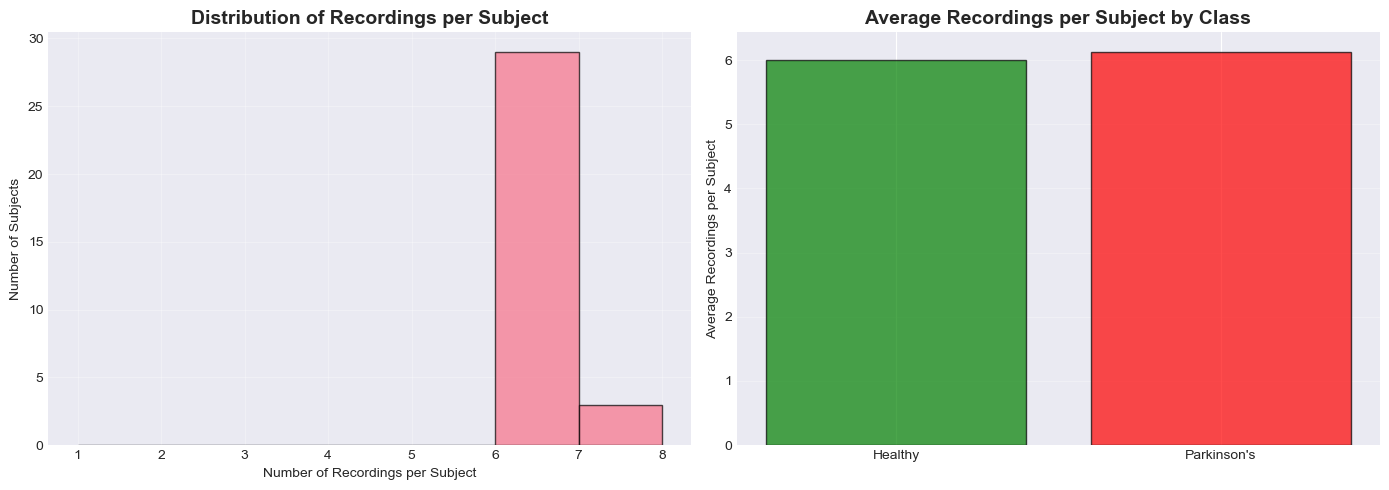


Average recordings per subject: 6.1
Min recordings: 6
Max recordings: 7


In [57]:
# Analyze recordings per subject
subject_analysis = df_voice.groupby('subject_id').agg({
    'status': 'first',
    'name': 'count'
}).rename(columns={'name': 'n_recordings'})

print("Recordings per subject:")
print(subject_analysis)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of recordings per subject
axes[0].hist(subject_analysis['n_recordings'], bins=range(1, subject_analysis['n_recordings'].max() + 2), 
             edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Recordings per Subject')
axes[0].set_ylabel('Number of Subjects')
axes[0].set_title('Distribution of Recordings per Subject', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Recordings by class
class_0_subjects = subject_analysis[subject_analysis['status'] == 0]
class_1_subjects = subject_analysis[subject_analysis['status'] == 1]

axes[1].bar(['Healthy', "Parkinson's"], 
            [class_0_subjects['n_recordings'].mean(), class_1_subjects['n_recordings'].mean()],
            color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Average Recordings per Subject')
axes[1].set_title('Average Recordings per Subject by Class', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/subject_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nAverage recordings per subject: {subject_analysis['n_recordings'].mean():.1f}")
print(f"Min recordings: {subject_analysis['n_recordings'].min()}")
print(f"Max recordings: {subject_analysis['n_recordings'].max()}")


### 3.4 Feature Distribution Histograms


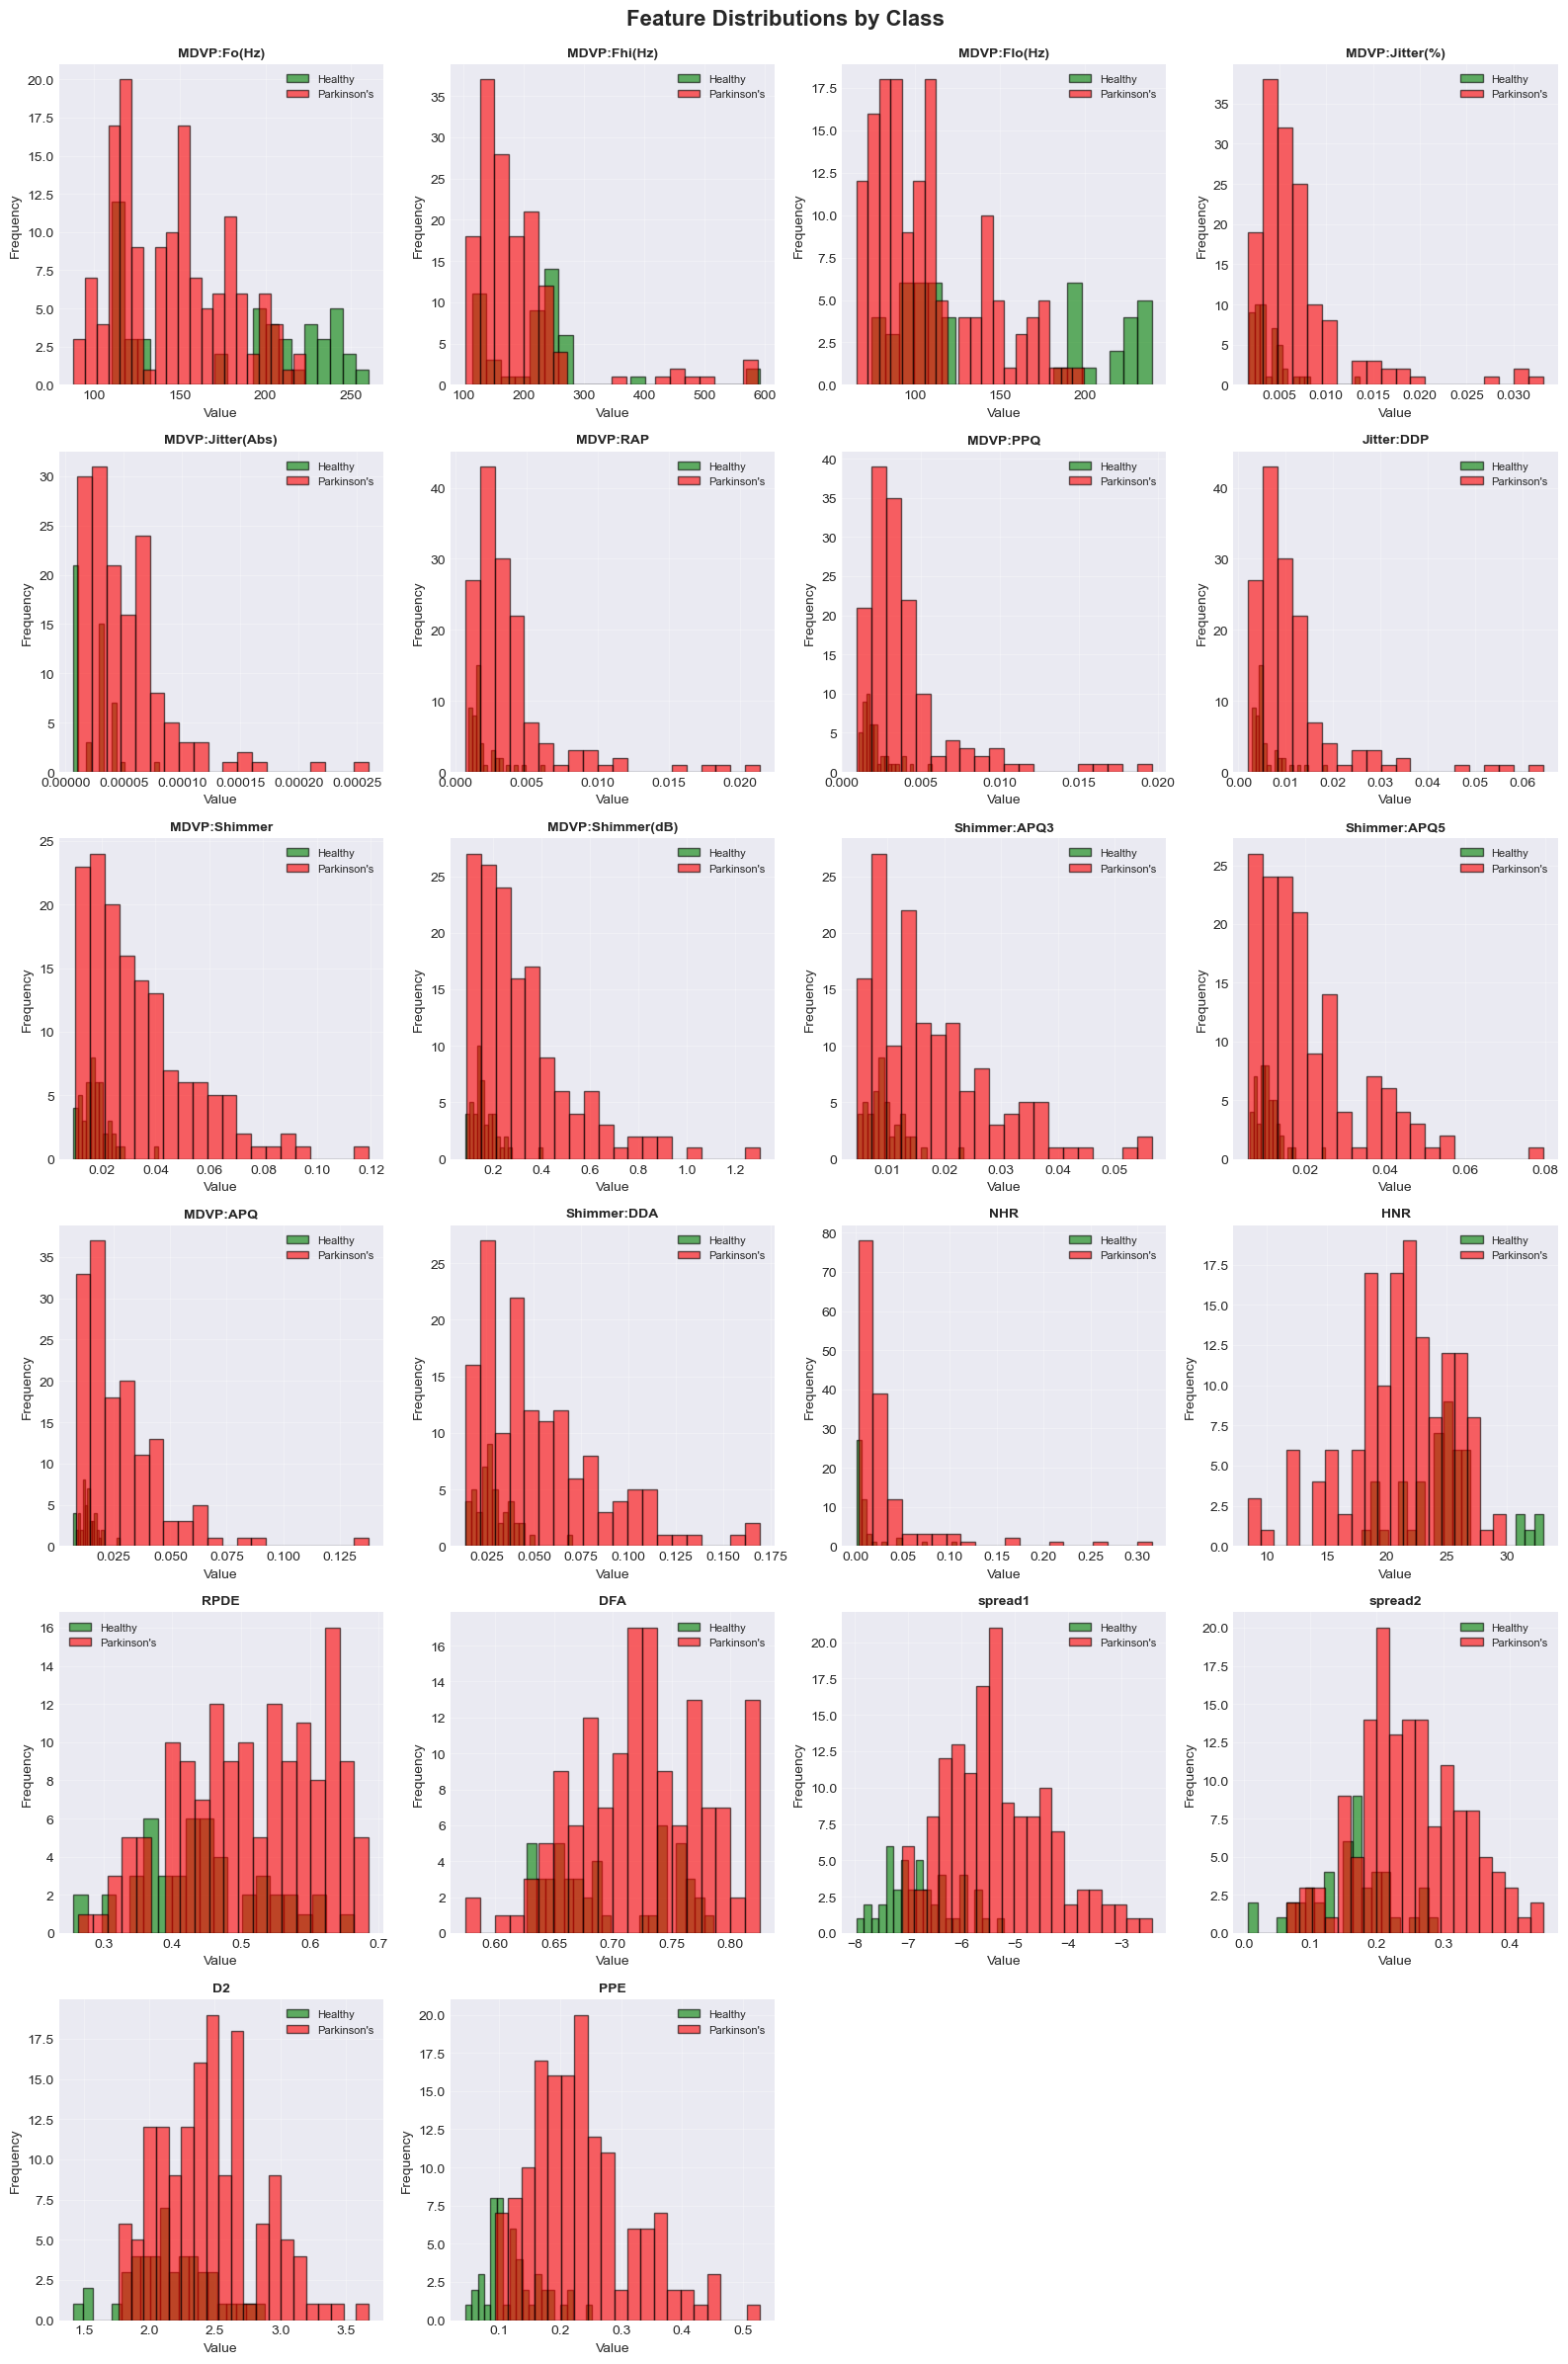

✓ Saved feature histograms to outputs/feature_histograms.png


In [58]:
# Plot histograms for all features, colored by class
n_features = len(feature_cols)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

for idx, feature in enumerate(feature_cols):
    ax = axes[idx]
    
    # Plot histograms for each class
    healthy_data = df_voice[df_voice['status'] == 0][feature]
    pd_data = df_voice[df_voice['status'] == 1][feature]
    
    ax.hist(healthy_data, bins=20, alpha=0.6, label='Healthy', color='green', edgecolor='black')
    ax.hist(pd_data, bins=20, alpha=0.6, label="Parkinson's", color='red', edgecolor='black')
    
    ax.set_title(feature, fontsize=10, fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Feature Distributions by Class', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/feature_histograms.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved feature histograms to {OUTPUT_DIR}/feature_histograms.png")


### 3.5 Correlation Matrix


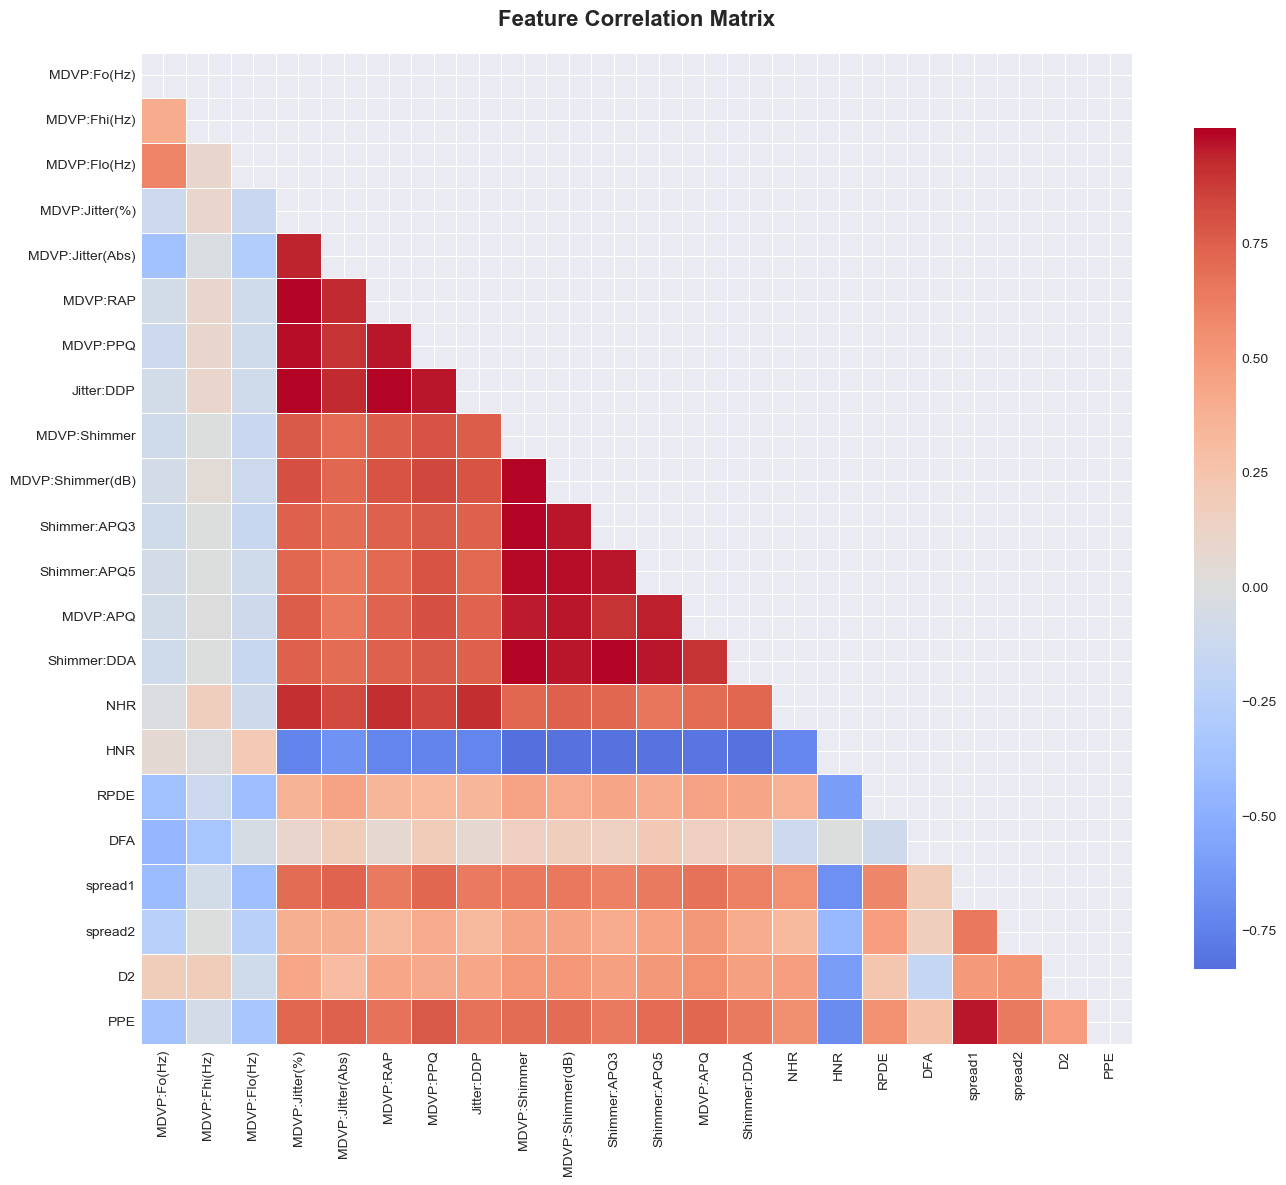

✓ Saved correlation matrix to outputs/correlation_matrix.png


In [59]:
# Compute correlation matrix
corr_matrix = df_features.corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, fmt='.2f')
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved correlation matrix to {OUTPUT_DIR}/correlation_matrix.png")


## 4. Data Preprocessing for Modeling


### 4.1 Standardization and PCA


Original number of features: 22
Number of PCA components (retaining 95.0% variance): 8
Actual variance explained: 95.77%

Explained variance per component:
  Component 1: 58.90%
  Component 2: 11.30%
  Component 3: 7.01%
  Component 4: 6.66%
  Component 5: 4.43%
  Component 6: 3.31%
  Component 7: 2.51%
  Component 8: 1.65%

Using first 4 PCA components for quantum kernel


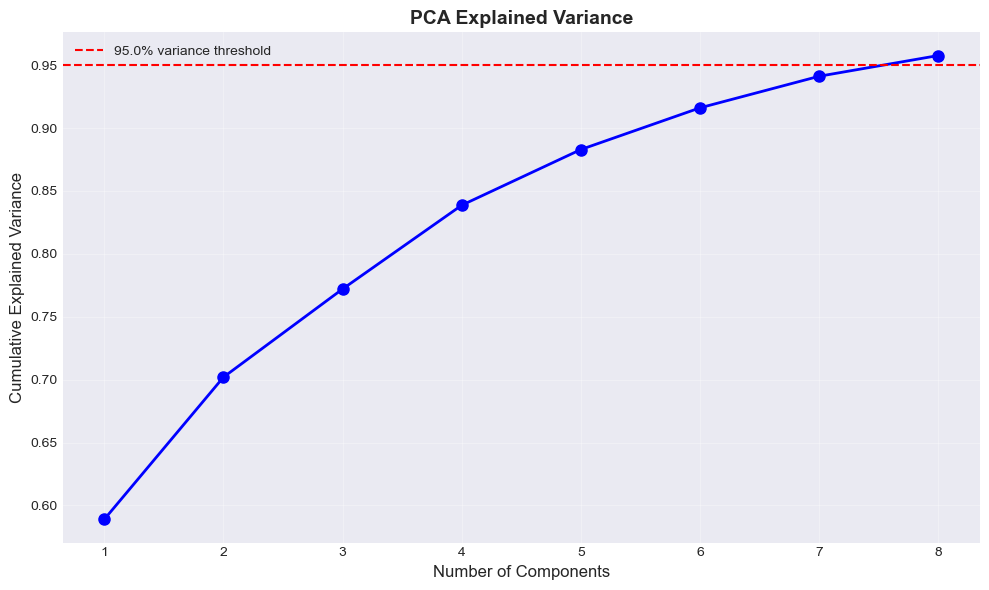

In [60]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=PCA_VARIANCE_THRESHOLD)  # Retain specified variance
X_pca = pca.fit_transform(X_scaled)

n_components_actual = X_pca.shape[1]
variance_explained = np.sum(pca.explained_variance_ratio_)

print(f"Original number of features: {X.shape[1]}")
print(f"Number of PCA components (retaining {PCA_VARIANCE_THRESHOLD*100}% variance): {n_components_actual}")
print(f"Actual variance explained: {variance_explained*100:.2f}%")
print(f"\nExplained variance per component:")
for i, var in enumerate(pca.explained_variance_ratio_[:10]):  # Show first 10
    print(f"  Component {i+1}: {var*100:.2f}%")

# Adjust N_QUBITS if needed
if n_components_actual < N_QUBITS:
    print(f"\n⚠️  Warning: N_QUBITS ({N_QUBITS}) > n_components ({n_components_actual}). Setting N_QUBITS = {n_components_actual}")
    N_QUBITS = n_components_actual
elif n_components_actual > N_QUBITS:
    # Use only first N_QUBITS components for quantum kernel
    X_pca_quantum = X_pca[:, :N_QUBITS]
    print(f"\nUsing first {N_QUBITS} PCA components for quantum kernel")
else:
    X_pca_quantum = X_pca

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 'bo-', linewidth=2, markersize=8)
plt.axhline(y=PCA_VARIANCE_THRESHOLD, color='r', linestyle='--', label=f'{PCA_VARIANCE_THRESHOLD*100}% variance threshold')
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('PCA Explained Variance', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/pca_variance.png', dpi=300, bbox_inches='tight')
plt.show()


### 4.2 Subject-wise Train/Test Split


In [61]:
# Function for subject-wise splitting to avoid data leakage
def subject_wise_split(X, y, subject_ids, test_size=0.2, random_state=42):
    """
    Split data such that all recordings from a subject are in the same fold.
    This prevents data leakage.
    """
    unique_subjects = np.unique(subject_ids)
    np.random.seed(random_state)
    np.random.shuffle(unique_subjects)
    
    n_test_subjects = int(len(unique_subjects) * test_size)
    test_subjects = unique_subjects[:n_test_subjects]
    train_subjects = unique_subjects[n_test_subjects:]
    
    train_mask = np.isin(subject_ids, train_subjects)
    test_mask = np.isin(subject_ids, test_subjects)
    
    return train_mask, test_mask

# Create initial train/test split
train_mask, test_mask = subject_wise_split(X_pca, y, subject_ids, test_size=TEST_SIZE, random_state=RANDOM_STATE)

X_train_full = X_pca[train_mask]
X_test = X_pca[test_mask]
y_train_full = y[train_mask]
y_test = y[test_mask]
subject_ids_train = subject_ids[train_mask]
subject_ids_test = subject_ids[test_mask]

print(f"Training set: {len(X_train_full)} samples from {len(np.unique(subject_ids_train))} subjects")
print(f"Test set: {len(X_test)} samples from {len(np.unique(subject_ids_test))} subjects")
print(f"\nTraining class distribution: {np.bincount(y_train_full)}")
print(f"Test class distribution: {np.bincount(y_test)}")


Training set: 158 samples from 26 subjects
Test set: 37 samples from 6 subjects

Training class distribution: [ 42 116]
Test class distribution: [ 6 31]


## 5. Classical Machine Learning Baselines


### 5.1 Subject-wise Cross-Validation Function



In [62]:
def subject_wise_cv(X, y, subject_ids, n_splits=5, random_state=42):
    """
    Generate subject-wise cross-validation splits.
    Ensures all recordings from a subject are in the same fold.
    """
    unique_subjects = np.unique(subject_ids)
    subject_labels = np.array([np.where(unique_subjects == sid)[0][0] for sid in subject_ids])
    
    # Use StratifiedKFold on subjects (not samples)
    # Get class label for each subject
    subject_classes = np.array([y[subject_ids == sid][0] for sid in unique_subjects])
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    for train_subj_idx, val_subj_idx in skf.split(unique_subjects, subject_classes):
        train_subjects = unique_subjects[train_subj_idx]
        val_subjects = unique_subjects[val_subj_idx]
        
        train_mask = np.isin(subject_ids, train_subjects)
        val_mask = np.isin(subject_ids, val_subjects)
        
        yield train_mask, val_mask

print("✓ Subject-wise CV function defined")


✓ Subject-wise CV function defined


### 5.2 Train Classical Models


In [63]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
    'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)
}

# Store results
classical_results = {name: {'auc_scores': [], 'acc_scores': [], 'sens_scores': [], 'spec_scores': []} 
                     for name in models.keys()}

print("Training classical models with subject-wise cross-validation...")
print("=" * 60)

for model_name, model in models.items():
    print(f"\n{model_name}:")
    
    for fold, (train_idx, val_idx) in enumerate(subject_wise_cv(X_train_full, y_train_full, 
                                                                 subject_ids_train, 
                                                                 n_splits=N_SPLITS, 
                                                                 random_state=RANDOM_STATE)):
        X_train_cv = X_train_full[train_idx]
        X_val_cv = X_train_full[val_idx]
        y_train_cv = y_train_full[train_idx]
        y_val_cv = y_train_full[val_idx]
        
        # Train model
        model.fit(X_train_cv, y_train_cv)
        
        # Predictions
        y_pred = model.predict(X_val_cv)
        y_pred_proba = model.predict_proba(X_val_cv)[:, 1]
        
        # Metrics
        auc = roc_auc_score(y_val_cv, y_pred_proba)
        acc = accuracy_score(y_val_cv, y_pred)
        
        # Sensitivity (recall) and Specificity
        tn, fp, fn, tp = confusion_matrix(y_val_cv, y_pred).ravel()
        sens = tp / (tp + fn) if (tp + fn) > 0 else 0
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        classical_results[model_name]['auc_scores'].append(auc)
        classical_results[model_name]['acc_scores'].append(acc)
        classical_results[model_name]['sens_scores'].append(sens)
        classical_results[model_name]['spec_scores'].append(spec)
        
        print(f"  Fold {fold+1}: AUC={auc:.3f}, Acc={acc:.3f}, Sens={sens:.3f}, Spec={spec:.3f}")
    
    # Print average results
    avg_auc = np.mean(classical_results[model_name]['auc_scores'])
    avg_acc = np.mean(classical_results[model_name]['acc_scores'])
    avg_sens = np.mean(classical_results[model_name]['sens_scores'])
    avg_spec = np.mean(classical_results[model_name]['spec_scores'])
    
    print(f"  Average: AUC={avg_auc:.3f}, Acc={avg_acc:.3f}, Sens={avg_sens:.3f}, Spec={avg_spec:.3f}")

print("\n" + "=" * 60)
print("✓ Classical models trained")


Training classical models with subject-wise cross-validation...

Logistic Regression:
  Fold 1: AUC=0.990, Acc=0.778, Sens=1.000, Spec=0.333
  Fold 2: AUC=1.000, Acc=0.867, Sens=0.833, Spec=1.000
  Fold 3: AUC=0.653, Acc=0.700, Sens=0.750, Spec=0.500
  Fold 4: AUC=0.660, Acc=0.800, Sens=1.000, Spec=0.000
  Fold 5: AUC=0.983, Acc=0.938, Sens=0.900, Spec=1.000
  Average: AUC=0.857, Acc=0.816, Sens=0.897, Spec=0.567

Random Forest:
  Fold 1: AUC=0.806, Acc=0.778, Sens=1.000, Spec=0.333
  Fold 2: AUC=1.000, Acc=1.000, Sens=1.000, Spec=1.000
  Fold 3: AUC=0.441, Acc=0.600, Sens=0.750, Spec=0.000
  Fold 4: AUC=0.625, Acc=0.800, Sens=1.000, Spec=0.000
  Fold 5: AUC=0.992, Acc=0.906, Sens=0.950, Spec=0.833
  Average: AUC=0.773, Acc=0.817, Sens=0.940, Spec=0.433

SVM (RBF):
  Fold 1: AUC=0.708, Acc=0.778, Sens=1.000, Spec=0.333
  Fold 2: AUC=1.000, Acc=1.000, Sens=1.000, Spec=1.000
  Fold 3: AUC=0.389, Acc=0.667, Sens=0.833, Spec=0.000
  Fold 4: AUC=0.521, Acc=0.800, Sens=1.000, Spec=0.000
  Fo

## 6. Quantum Kernel SVM Implementation


### 6.1 Quantum Feature Map Setup

We'll use an angle-encoding quantum feature map that encodes classical features into quantum states using rotation gates.


In [33]:
# Configure PennyLane device
if USE_HARDWARE:
    # For IBM Quantum hardware (requires credentials)
    # from qiskit import IBMQ
    # IBMQ.load_account()
    # dev = qml.device('qiskit.ibmq', wires=N_QUBITS, backend=IBM_DEVICE)
    print("⚠️  Hardware mode not fully configured. Using simulator.")
    dev = qml.device('default.qubit', wires=N_QUBITS)
else:
    # Use local simulator
    dev = qml.device('default.qubit', wires=N_QUBITS)

print(f"Using device: {dev.name}")
print(f"Number of qubits: {N_QUBITS}")
print(f"Number of layers: {N_LAYERS}")


Using device: default.qubit
Number of qubits: 4
Number of layers: 2


In [34]:
# Define quantum feature map with angle encoding
@qml.qnode(dev)
def quantum_feature_map(x, params):
    """
    Quantum feature map using angle encoding.
    
    Args:
        x: Input features (normalized to [0, π])
        params: Variational parameters for entangling layers
    
    Returns:
        Quantum state measurement
    """
    # Angle encoding: encode features as rotation angles
    for i in range(N_QUBITS):
        qml.RY(x[i], wires=i)
    
    # Entangling layers with variational parameters
    for layer in range(N_LAYERS):
        # Entangling gates
        for i in range(N_QUBITS - 1):
            qml.CNOT(wires=[i, i + 1])
        
        # Variational rotations
        param_idx = layer * N_QUBITS
        for i in range(N_QUBITS):
            if param_idx + i < len(params):
                qml.RY(params[param_idx + i], wires=i)
    
    # Measure in computational basis
    return qml.state()

# Alternative: simpler feature map for kernel computation
@qml.qnode(dev)
def quantum_kernel_circuit(x1, x2):
    """
    Quantum kernel circuit that computes |<φ(x1)|φ(x2)>|²
    This is the fidelity between two quantum states.
    Uses the SWAP test approach for kernel computation.
    """
    # Encode first data point
    for i in range(N_QUBITS):
        qml.RY(x1[i], wires=i)
    
    # Adjoint encoding of second data point (reverse order)
    for i in range(N_QUBITS - 1, -1, -1):
        qml.RY(-x2[i], wires=i)
    
    # Return probability distribution (will index [0] for |0...0> state after execution)
    return qml.probs(wires=range(N_QUBITS))

print("✓ Quantum feature map defined")


✓ Quantum feature map defined


### 6.2 Quantum Kernel Matrix Computation

The quantum kernel is computed as the overlap between quantum states: K(x_i, x_j) = |<φ(x_i)|φ(x_j)>|²


In [35]:
def compute_quantum_kernel(X1, X2=None):
    """
    Compute quantum kernel matrix.
    
    Args:
        X1: First set of data points (n_samples1, n_features)
        X2: Second set of data points (n_samples2, n_features). If None, X2 = X1.
    
    Returns:
        Kernel matrix of shape (n_samples1, n_samples2)
    """
    if X2 is None:
        X2 = X1
    
    # Normalize features to [0, π] for angle encoding
    # Assuming features are already normalized (from StandardScaler)
    X1_norm = (X1 - X1.min(axis=0)) / (X1.max(axis=0) - X1.min(axis=0) + 1e-10) * np.pi
    X2_norm = (X2 - X2.min(axis=0)) / (X2.max(axis=0) - X2.min(axis=0) + 1e-10) * np.pi
    
    # Ensure we only use first N_QUBITS features
    if X1_norm.shape[1] > N_QUBITS:
        X1_norm = X1_norm[:, :N_QUBITS]
    if X2_norm.shape[1] > N_QUBITS:
        X2_norm = X2_norm[:, :N_QUBITS]
    
    n1 = X1_norm.shape[0]
    n2 = X2_norm.shape[0]
    kernel_matrix = np.zeros((n1, n2))
    
    print(f"Computing quantum kernel matrix ({n1} x {n2})...")
    from tqdm import tqdm
    
    for i in tqdm(range(n1), desc="Computing kernel"):
        for j in range(n2):
            # Compute overlap using quantum circuit
            # Kernel value is |<φ(x1)|φ(x2)>|² = probability of |0...0> state
            probs = quantum_kernel_circuit(X1_norm[i], X2_norm[j])
            # Extract probability of |0...0> state (first element of probability array)
            kernel_value = probs[0]
            kernel_matrix[i, j] = float(kernel_value)
    
    return kernel_matrix

print("✓ Quantum kernel computation function defined")


✓ Quantum kernel computation function defined


### 6.3 Train Quantum Kernel SVM with Cross-Validation


In [36]:
# Prepare quantum data (use first N_QUBITS PCA components)
X_train_quantum = X_train_full[:, :N_QUBITS] if X_train_full.shape[1] >= N_QUBITS else X_train_full
X_test_quantum = X_test[:, :N_QUBITS] if X_test.shape[1] >= N_QUBITS else X_test

# Store quantum results
quantum_results = {'auc_scores': [], 'acc_scores': [], 'sens_scores': [], 'spec_scores': []}

print("Training Quantum Kernel SVM with subject-wise cross-validation...")
print("=" * 60)

for fold, (train_idx, val_idx) in enumerate(subject_wise_cv(X_train_quantum, y_train_full, 
                                                             subject_ids_train, 
                                                             n_splits=N_SPLITS, 
                                                             random_state=RANDOM_STATE)):
    print(f"\nFold {fold+1}/{N_SPLITS}:")
    
    X_train_cv = X_train_quantum[train_idx]
    X_val_cv = X_train_quantum[val_idx]
    y_train_cv = y_train_full[train_idx]
    y_val_cv = y_train_full[val_idx]
    
    # Compute quantum kernel matrices
    print("  Computing training kernel matrix...")
    K_train = compute_quantum_kernel(X_train_cv)
    
    print("  Computing validation kernel matrix...")
    # For sklearn's precomputed kernel, validation kernel must be (n_val, n_train)
    # So we swap arguments: validation samples (rows) × training samples (columns)
    K_val = compute_quantum_kernel(X_val_cv, X_train_cv)
    
    # Train SVM with precomputed kernel
    svm_quantum = SVC(kernel='precomputed', probability=True, random_state=RANDOM_STATE)
    svm_quantum.fit(K_train, y_train_cv)
    
    # Predictions
    y_pred = svm_quantum.predict(K_val)
    y_pred_proba = svm_quantum.predict_proba(K_val)[:, 1]
    
    # Metrics
    auc = roc_auc_score(y_val_cv, y_pred_proba)
    acc = accuracy_score(y_val_cv, y_pred)
    
    # Sensitivity and Specificity
    tn, fp, fn, tp = confusion_matrix(y_val_cv, y_pred).ravel()
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    quantum_results['auc_scores'].append(auc)
    quantum_results['acc_scores'].append(acc)
    quantum_results['sens_scores'].append(sens)
    quantum_results['spec_scores'].append(spec)
    
    print(f"  Results: AUC={auc:.3f}, Acc={acc:.3f}, Sens={sens:.3f}, Spec={spec:.3f}")

# Print average results
avg_auc = np.mean(quantum_results['auc_scores'])
avg_acc = np.mean(quantum_results['acc_scores'])
avg_sens = np.mean(quantum_results['sens_scores'])
avg_spec = np.mean(quantum_results['spec_scores'])

print(f"\n{'=' * 60}")
print(f"Quantum Kernel SVM Average Results:")
print(f"  AUC={avg_auc:.3f}, Acc={avg_acc:.3f}, Sens={avg_sens:.3f}, Spec={avg_spec:.3f}")
print("=" * 60)


Training Quantum Kernel SVM with subject-wise cross-validation...

Fold 1/5:
  Computing training kernel matrix...
Computing quantum kernel matrix (122 x 122)...


Computing kernel: 100%|███████████████████████| 122/122 [00:05<00:00, 21.09it/s]


  Computing validation kernel matrix...
Computing quantum kernel matrix (36 x 122)...


Computing kernel: 100%|█████████████████████████| 36/36 [00:01<00:00, 21.87it/s]


  Results: AUC=0.927, Acc=0.778, Sens=1.000, Spec=0.333

Fold 2/5:
  Computing training kernel matrix...
Computing quantum kernel matrix (128 x 128)...


Computing kernel: 100%|███████████████████████| 128/128 [00:06<00:00, 19.88it/s]


  Computing validation kernel matrix...
Computing quantum kernel matrix (30 x 128)...


Computing kernel: 100%|█████████████████████████| 30/30 [00:01<00:00, 19.87it/s]


  Results: AUC=1.000, Acc=1.000, Sens=1.000, Spec=1.000

Fold 3/5:
  Computing training kernel matrix...
Computing quantum kernel matrix (128 x 128)...


Computing kernel: 100%|███████████████████████| 128/128 [00:06<00:00, 19.79it/s]


  Computing validation kernel matrix...
Computing quantum kernel matrix (30 x 128)...


Computing kernel: 100%|█████████████████████████| 30/30 [00:01<00:00, 19.73it/s]


  Results: AUC=0.486, Acc=0.667, Sens=0.750, Spec=0.333

Fold 4/5:
  Computing training kernel matrix...
Computing quantum kernel matrix (128 x 128)...


Computing kernel: 100%|███████████████████████| 128/128 [00:06<00:00, 19.70it/s]


  Computing validation kernel matrix...
Computing quantum kernel matrix (30 x 128)...


Computing kernel: 100%|█████████████████████████| 30/30 [00:01<00:00, 19.81it/s]


  Results: AUC=0.771, Acc=0.700, Sens=0.833, Spec=0.167

Fold 5/5:
  Computing training kernel matrix...
Computing quantum kernel matrix (126 x 126)...


Computing kernel: 100%|███████████████████████| 126/126 [00:06<00:00, 20.12it/s]


  Computing validation kernel matrix...
Computing quantum kernel matrix (32 x 126)...


Computing kernel: 100%|█████████████████████████| 32/32 [00:01<00:00, 20.10it/s]

  Results: AUC=0.971, Acc=0.750, Sens=1.000, Spec=0.333

Quantum Kernel SVM Average Results:
  AUC=0.831, Acc=0.779, Sens=0.917, Spec=0.433


## 7. Results Comparison and Visualization


### 7.1 Bootstrap Confidence Intervals

We use bootstrap resampling to compute confidence intervals for all metrics.


In [37]:
def bootstrap_ci(data, n_bootstrap=1000, confidence_level=0.95):
    """
    Compute bootstrap confidence intervals.
    
    Args:
        data: Array of metric values
        n_bootstrap: Number of bootstrap samples
        confidence_level: Confidence level (e.g., 0.95 for 95% CI)
    
    Returns:
        (mean, lower_bound, upper_bound)
    """
    bootstrap_samples = []
    n = len(data)
    
    for _ in range(n_bootstrap):
        # Resample with replacement
        bootstrap_sample = np.random.choice(data, size=n, replace=True)
        bootstrap_samples.append(np.mean(bootstrap_sample))
    
    bootstrap_samples = np.array(bootstrap_samples)
    alpha = 1 - confidence_level
    lower = np.percentile(bootstrap_samples, 100 * alpha / 2)
    upper = np.percentile(bootstrap_samples, 100 * (1 - alpha / 2))
    mean = np.mean(data)
    
    return mean, lower, upper

# Compute bootstrap CIs for all models
all_results = {}
for model_name in classical_results.keys():
    all_results[model_name] = {}
    for metric in ['auc_scores', 'acc_scores', 'sens_scores', 'spec_scores']:
        mean, lower, upper = bootstrap_ci(classical_results[model_name][metric], 
                                          n_bootstrap=N_BOOTSTRAP, 
                                          confidence_level=CONFIDENCE_LEVEL)
        all_results[model_name][metric] = {'mean': mean, 'lower': lower, 'upper': upper}

# Quantum results
all_results['Quantum Kernel SVM'] = {}
for metric in ['auc_scores', 'acc_scores', 'sens_scores', 'spec_scores']:
    mean, lower, upper = bootstrap_ci(quantum_results[metric], 
                                      n_bootstrap=N_BOOTSTRAP, 
                                      confidence_level=CONFIDENCE_LEVEL)
    all_results['Quantum Kernel SVM'][metric] = {'mean': mean, 'lower': lower, 'upper': upper}

print("✓ Bootstrap confidence intervals computed")


✓ Bootstrap confidence intervals computed


### 7.2 Results Table


In [38]:
# Create results table
results_table = []

for model_name in all_results.keys():
    row = {
        'Model': model_name,
        'ROC-AUC': f"{all_results[model_name]['auc_scores']['mean']:.3f} "
                   f"({all_results[model_name]['auc_scores']['lower']:.3f}-{all_results[model_name]['auc_scores']['upper']:.3f})",
        'Accuracy': f"{all_results[model_name]['acc_scores']['mean']:.3f} "
                   f"({all_results[model_name]['acc_scores']['lower']:.3f}-{all_results[model_name]['acc_scores']['upper']:.3f})",
        'Sensitivity': f"{all_results[model_name]['sens_scores']['mean']:.3f} "
                      f"({all_results[model_name]['sens_scores']['lower']:.3f}-{all_results[model_name]['sens_scores']['upper']:.3f})",
        'Specificity': f"{all_results[model_name]['spec_scores']['mean']:.3f} "
                      f"({all_results[model_name]['spec_scores']['lower']:.3f}-{all_results[model_name]['spec_scores']['upper']:.3f})"
    }
    results_table.append(row)

df_results = pd.DataFrame(results_table)
print("Results Summary (with 95% Bootstrap Confidence Intervals):")
print("=" * 100)
print(df_results.to_string(index=False))
print("=" * 100)

# Save to CSV
df_results.to_csv(f'{OUTPUT_DIR}/results_summary.csv', index=False)
print(f"\n✓ Saved results to {OUTPUT_DIR}/results_summary.csv")


Results Summary (with 95% Bootstrap Confidence Intervals):
              Model             ROC-AUC            Accuracy         Sensitivity         Specificity
Logistic Regression 0.857 (0.721-0.991) 0.816 (0.751-0.883) 0.897 (0.810-0.980) 0.567 (0.233-0.900)
      Random Forest 0.773 (0.588-0.958) 0.817 (0.697-0.920) 0.940 (0.850-1.000) 0.433 (0.067-0.800)
          SVM (RBF) 0.723 (0.505-0.940) 0.836 (0.738-0.943) 0.967 (0.900-1.000) 0.433 (0.067-0.801)
 Quantum Kernel SVM 0.831 (0.662-0.968) 0.779 (0.697-0.900) 0.917 (0.817-1.000) 0.433 (0.233-0.733)

✓ Saved results to outputs/results_summary.csv


### 7.3 Visualization: Metric Comparison


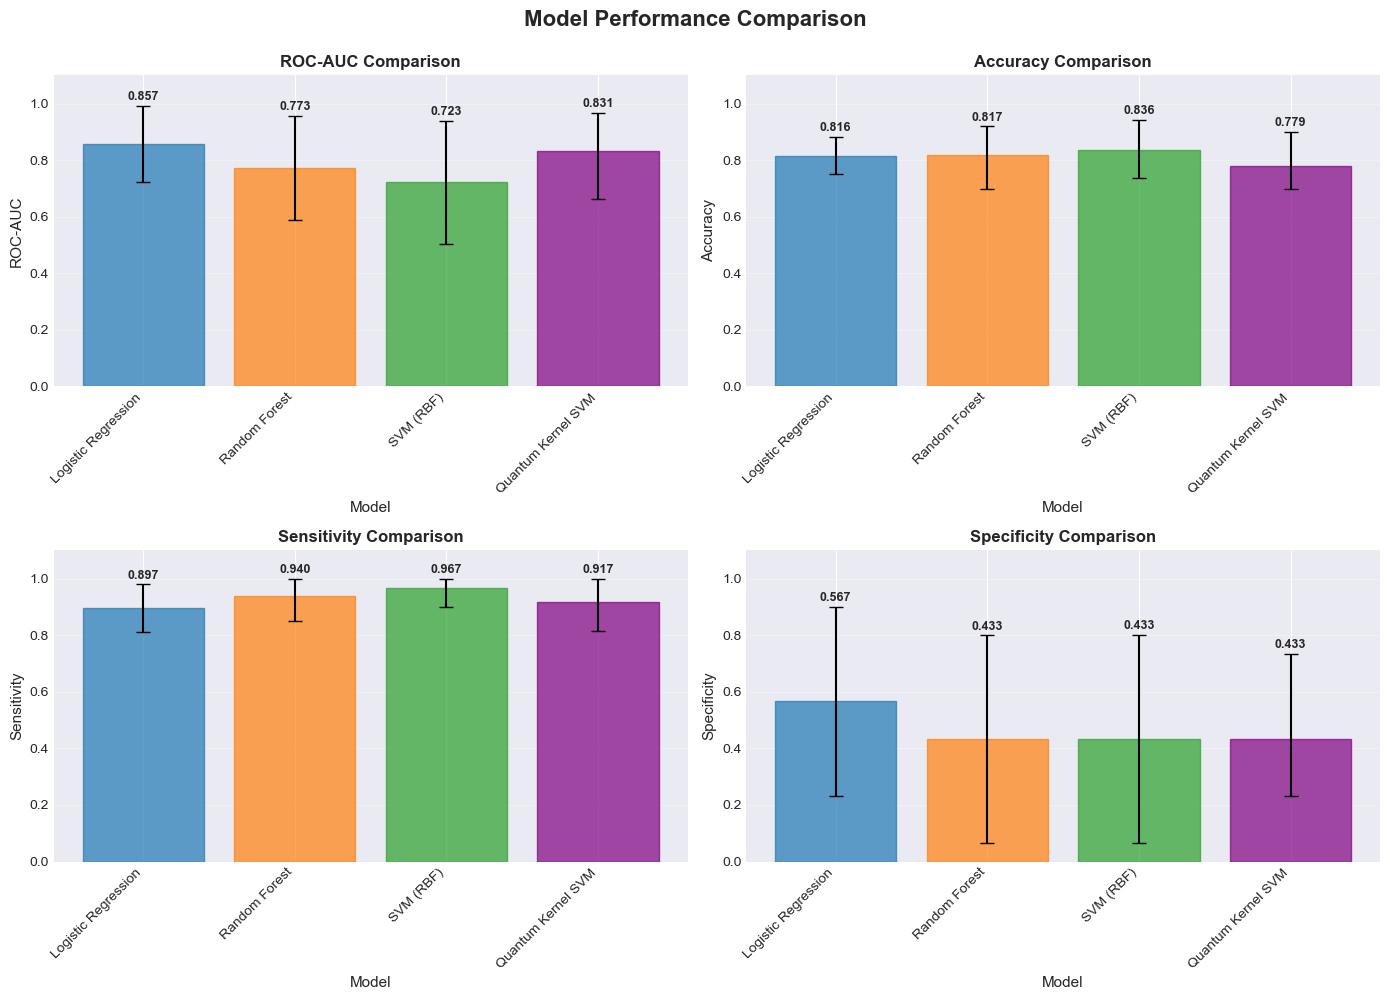

✓ Saved metrics comparison to outputs/metrics_comparison.png


In [39]:
# Plot comparison of metrics
metrics = ['auc_scores', 'acc_scores', 'sens_scores', 'spec_scores']
metric_names = ['ROC-AUC', 'Accuracy', 'Sensitivity', 'Specificity']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    ax = axes[idx]
    
    model_names = list(all_results.keys())
    means = [all_results[name][metric]['mean'] for name in model_names]
    lowers = [all_results[name][metric]['lower'] for name in model_names]
    uppers = [all_results[name][metric]['upper'] for name in model_names]
    errors = [[m - l for m, l in zip(means, lowers)], 
              [u - m for u, m in zip(uppers, means)]]
    
    x_pos = np.arange(len(model_names))
    bars = ax.bar(x_pos, means, yerr=errors, capsize=5, alpha=0.7, edgecolor='black')
    
    # Color quantum model differently
    for i, (bar, name) in enumerate(zip(bars, model_names)):
        if 'Quantum' in name:
            bar.set_color('purple')
        else:
            bar.set_color(plt.cm.tab10(i))
    
    ax.set_xlabel('Model', fontsize=11)
    ax.set_ylabel(metric_name, fontsize=11)
    ax.set_title(f'{metric_name} Comparison', fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    ax.set_ylim([0, 1.1])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (mean, lower, upper) in enumerate(zip(means, lowers, uppers)):
        ax.text(i, mean + (upper - mean) + 0.02, f'{mean:.3f}', 
               ha='center', fontsize=9, fontweight='bold')

plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved metrics comparison to {OUTPUT_DIR}/metrics_comparison.png")


### 7.4 ROC Curves


Training final models on full training set...
Computing quantum kernel for final model...
Computing quantum kernel matrix (158 x 158)...


Computing kernel: 100%|███████████████████████| 158/158 [00:09<00:00, 15.97it/s]


Computing quantum kernel matrix (37 x 158)...


Computing kernel: 100%|█████████████████████████| 37/37 [00:02<00:00, 16.01it/s]


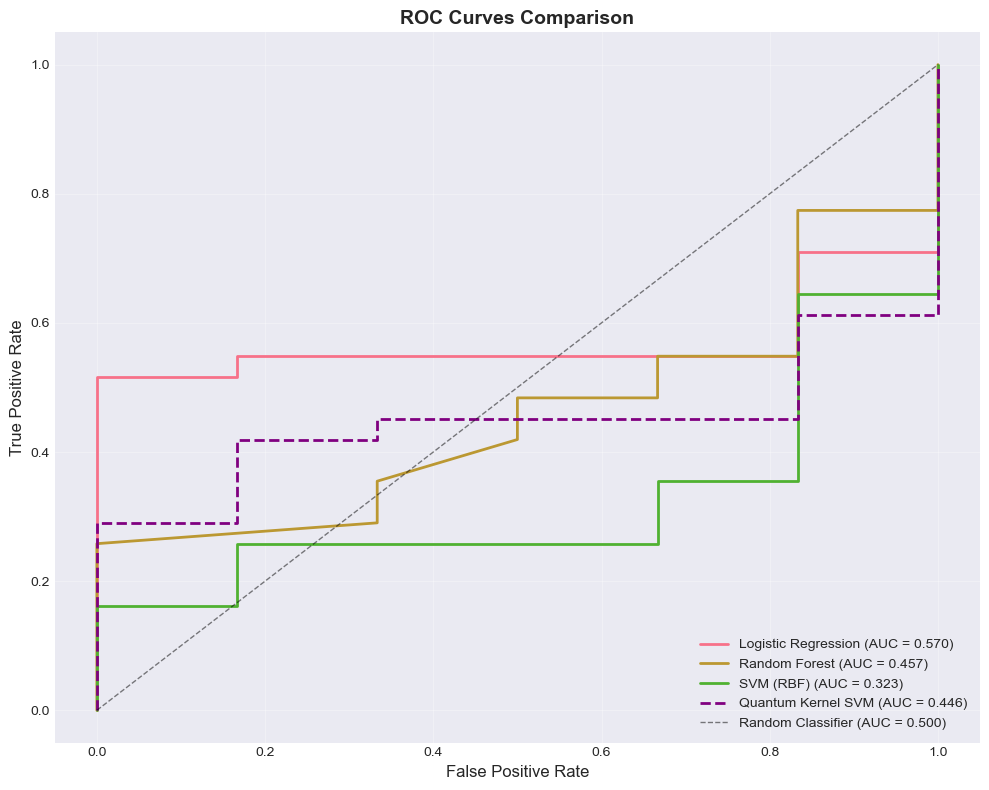

✓ Saved ROC curves to outputs/roc_curves.png


In [40]:
# Train final models on full training set and evaluate on test set
print("Training final models on full training set...")

# Classical models
final_classical_models = {}
for model_name, model in models.items():
    model.fit(X_train_full, y_train_full)
    final_classical_models[model_name] = model

# Quantum kernel SVM
print("Computing quantum kernel for final model...")
K_train_final = compute_quantum_kernel(X_train_quantum)
# For sklearn's precomputed kernel, test kernel must be (n_test, n_train)
# So we swap arguments: test samples (rows) × training samples (columns)
K_test_final = compute_quantum_kernel(X_test_quantum, X_train_quantum)

svm_quantum_final = SVC(kernel='precomputed', probability=True, random_state=RANDOM_STATE)
svm_quantum_final.fit(K_train_final, y_train_full)

# Compute ROC curves
plt.figure(figsize=(10, 8))

# Classical models
for model_name, model in final_classical_models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})', linewidth=2)

# Quantum model
y_pred_proba_quantum = svm_quantum_final.predict_proba(K_test_final)[:, 1]
fpr_q, tpr_q, _ = roc_curve(y_test, y_pred_proba_quantum)
auc_q = roc_auc_score(y_test, y_pred_proba_quantum)
plt.plot(fpr_q, tpr_q, label=f'Quantum Kernel SVM (AUC = {auc_q:.3f})', 
         linewidth=2, linestyle='--', color='purple')

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.500)', linewidth=1, alpha=0.5)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved ROC curves to {OUTPUT_DIR}/roc_curves.png")


### 7.5 Confusion Matrices


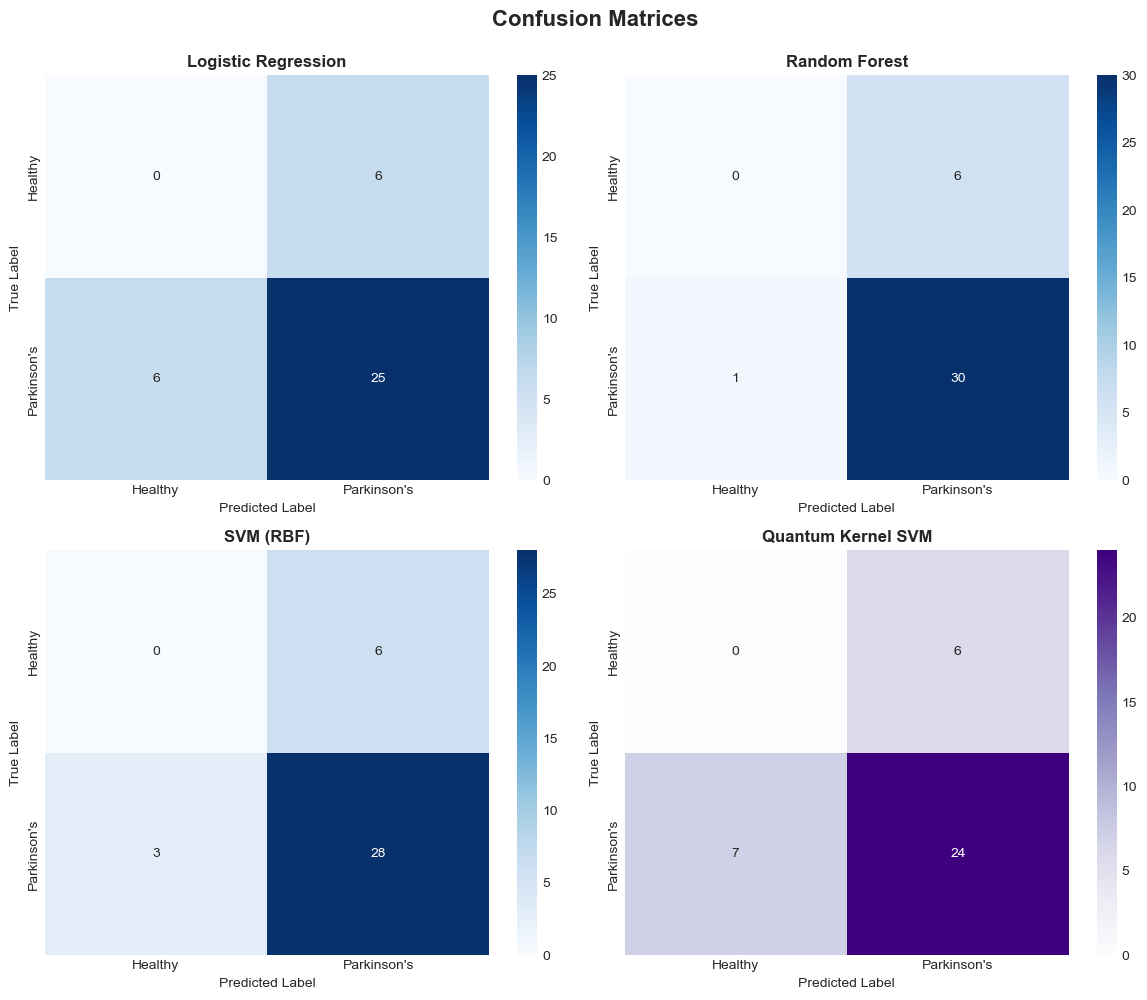

✓ Saved confusion matrices to outputs/confusion_matrices.png


In [41]:
# Plot confusion matrices for all models
n_models = len(final_classical_models) + 1
n_cols = 2
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
axes = axes.flatten()

model_idx = 0

# Classical models
for model_name, model in final_classical_models.items():
    ax = axes[model_idx]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                xticklabels=['Healthy', "Parkinson's"], 
                yticklabels=['Healthy', "Parkinson's"])
    ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=10)
    ax.set_xlabel('Predicted Label', fontsize=10)
    model_idx += 1

# Quantum model
ax = axes[model_idx]
y_pred_quantum = svm_quantum_final.predict(K_test_final)
cm_quantum = confusion_matrix(y_test, y_pred_quantum)

sns.heatmap(cm_quantum, annot=True, fmt='d', cmap='Purples', ax=ax,
            xticklabels=['Healthy', "Parkinson's"], 
            yticklabels=['Healthy', "Parkinson's"])
ax.set_title('Quantum Kernel SVM', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=10)
ax.set_xlabel('Predicted Label', fontsize=10)

# Hide unused subplots
for idx in range(model_idx + 1, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Confusion Matrices', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved confusion matrices to {OUTPUT_DIR}/confusion_matrices.png")


## 8. Save Models and Kernel Matrices


In [42]:
import joblib

# Save classical models
for model_name, model in final_classical_models.items():
    filename = f'{OUTPUT_DIR}/model_{model_name.replace(" ", "_").lower()}.pkl'
    joblib.dump(model, filename)
    print(f"✓ Saved {model_name} to {filename}")

# Save quantum kernel SVM
joblib.dump(svm_quantum_final, f'{OUTPUT_DIR}/model_quantum_kernel_svm.pkl')
print(f"✓ Saved Quantum Kernel SVM to {OUTPUT_DIR}/model_quantum_kernel_svm.pkl")

# Save kernel matrices
np.save(f'{OUTPUT_DIR}/quantum_kernel_train.npy', K_train_final)
np.save(f'{OUTPUT_DIR}/quantum_kernel_test.npy', K_test_final)
print(f"✓ Saved kernel matrices to {OUTPUT_DIR}/")

# Save scaler and PCA
joblib.dump(scaler, f'{OUTPUT_DIR}/scaler.pkl')
joblib.dump(pca, f'{OUTPUT_DIR}/pca.pkl')
print(f"✓ Saved preprocessing objects to {OUTPUT_DIR}/")


✓ Saved Logistic Regression to outputs/model_logistic_regression.pkl
✓ Saved Random Forest to outputs/model_random_forest.pkl
✓ Saved SVM (RBF) to outputs/model_svm_(rbf).pkl
✓ Saved Quantum Kernel SVM to outputs/model_quantum_kernel_svm.pkl
✓ Saved kernel matrices to outputs/
✓ Saved preprocessing objects to outputs/
